<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/3-Practical/FinRL_MultiCrypto_Trading.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Multiple Cryptocurrencies Trading Demo

## Installation

In [16]:
import sys
import os

# Install required packages
!pip install stable-baselines3
!pip install gymnasium
!pip install python-binance
!pip install pandas numpy matplotlib
!pip install stockstats

## Import Related Packages

In [17]:
import numpy as np
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env

## Functions for Training and Testing

In [3]:
from agents.elegantrl_models import DRLAgent as DRLAgent_erl
from agents.rllib_models import DRLAgent as DRLAgent_rllib
from agents.stablebaselines3_models import DRLAgent as DRLAgent_sb3
from meta.data_processor import DataProcessor

def train(start_date, end_date, ticker_list, data_source, time_interval, 
          technical_indicator_list, drl_lib, env, model_name, if_vix=True,
          **kwargs):
    
    #process data using unified data processor
    DP = DataProcessor(data_source, start_date, end_date, time_interval, **kwargs)
    price_array, tech_array, turbulence_array = DP.run(ticker_list,
                                                        technical_indicator_list, 
                                                        if_vix, cache=True)

    data_config = {'price_array': price_array,
                   'tech_array': tech_array,
                   'turbulence_array': turbulence_array}

    #build environment using processed data
    env_instance = env(config=data_config)

    #read parameters and load agents
    current_working_dir = kwargs.get('current_working_dir','./'+str(model_name))

    if drl_lib == 'elegantrl':
        break_step = kwargs.get('break_step', 1e6)
        erl_params = kwargs.get('erl_params')

        agent = DRLAgent_erl(env = env,
                             price_array = price_array,
                             tech_array=tech_array,
                             turbulence_array=turbulence_array)

        model = agent.get_model(model_name, model_kwargs = erl_params)

        trained_model = agent.train_model(model=model, 
                                          cwd=current_working_dir,
                                          total_timesteps=break_step)
        
      
    elif drl_lib == 'rllib':
        total_episodes = kwargs.get('total_episodes', 100)
        rllib_params = kwargs.get('rllib_params')

        agent_rllib = DRLAgent_rllib(env = env,
                       price_array=price_array,
                       tech_array=tech_array,
                       turbulence_array=turbulence_array)

        model,model_config = agent_rllib.get_model(model_name)

        model_config['lr'] = rllib_params['lr']
        model_config['train_batch_size'] = rllib_params['train_batch_size']
        model_config['gamma'] = rllib_params['gamma']

        trained_model = agent_rllib.train_model(model=model, 
                                          model_name=model_name,
                                          model_config=model_config,
                                          total_episodes=total_episodes)
        trained_model.save(current_working_dir)
        
            
    elif drl_lib == 'stable_baselines3':
        total_timesteps = kwargs.get('total_timesteps', 1e6)
        agent_params = kwargs.get('agent_params')

        agent = DRLAgent_sb3(env = env_instance)

        model = agent.get_model(model_name, model_kwargs = agent_params)
        trained_model = agent.train_model(model=model, 
                                tb_log_name=model_name,
                                total_timesteps=total_timesteps)
        print('Training finished!')
        trained_model.save(current_working_dir)
        print('Trained model saved in ' + str(current_working_dir))
    else:
        raise ValueError('DRL library input is NOT supported. Please check.')

ModuleNotFoundError: No module named 'ray'

In [ ]:
# import DRL agents
from agents.stablebaselines3_models import DRLAgent as DRLAgent_sb3
from agents.rllib_models import DRLAgent as DRLAgent_rllib
from agents.elegantrl_models import DRLAgent as DRLAgent_erl

# import data processor
from meta.data_processor import DataProcessor

def test(start_date, end_date, ticker_list, data_source, time_interval,
            technical_indicator_list, drl_lib, env, model_name, if_vix=True,
            **kwargs):
  
    #process data using unified data processor
    DP = DataProcessor(data_source, start_date, end_date, time_interval, **kwargs)
    price_array, tech_array, turbulence_array = DP.run(ticker_list,
                                                        technical_indicator_list, 
                                                        if_vix, cache=True)
    
    
    np.save('./price_array.npy', price_array)
    data_config = {'price_array':price_array,
                   'tech_array':tech_array,
                   'turbulence_array':turbulence_array}
    #build environment using processed data
    env_instance = env(config=data_config)

    env_config = {
        "price_array": price_array,
        "tech_array": tech_array,
        "turbulence_array": turbulence_array,
        "if_train": False,
    }
    env_instance = env(config=env_config)

    # load elegantrl needs state dim, action dim and net dim
    net_dimension = kwargs.get("net_dimension", 2 ** 7)
    current_working_dir = kwargs.get("current_working_dir", "./" + str(model_name))
    print("price_array: ", len(price_array))

    if drl_lib == "elegantrl":
        episode_total_assets = DRLAgent_erl.DRL_prediction(
            model_name=model_name,
            cwd=current_working_dir,
            net_dimension=net_dimension,
            environment=env_instance,
        )

        return episode_total_assets

    elif drl_lib == "rllib":
        # load agent
        episode_total_assets = DRLAgent_rllib.DRL_prediction(
            model_name=model_name,
            env=env,
            price_array=price_array,
            tech_array=tech_array,
            turbulence_array=turbulence_array,
            agent_path=current_working_dir,
        )

        return episode_total_assets

    elif drl_lib == "stable_baselines3":
        episode_total_assets = DRLAgent_sb3.DRL_prediction_load_from_file(
            model_name=model_name, environment=env_instance, cwd=current_working_dir
        )

        return episode_total_assets
    else:
        raise ValueError("DRL library input is NOT supported. Please check.")


## Multiple Cryptocurrencies Trading Env

In [18]:
import numpy as np
import math
import gymnasium as gym
from gymnasium import spaces

class CryptoEnv(gym.Env):  # custom env
    def __init__(self, config, lookback=1, initial_capital=1e6, 
                 buy_cost_pct=1e-3, sell_cost_pct=1e-3, gamma=0.99):
        super(CryptoEnv, self).__init__()
        
        self.lookback = lookback
        self.initial_total_asset = initial_capital
        self.initial_cash = initial_capital
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.max_stock = 1
        self.gamma = gamma
        self.price_array = config['price_array']
        self.tech_array = config['tech_array']
        self._generate_action_normalizer()
        self.crypto_num = self.price_array.shape[1]
        self.max_step = self.price_array.shape[0] - lookback - 1
        
        # Define action space and observation space
        self.action_space = spaces.Box(
            low=-1, high=1, shape=(self.crypto_num,), dtype=np.float32
        )
        
        # State space: cash + stocks + technical indicators
        state_dim = 1 + self.crypto_num + self.tech_array.shape[1]
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(state_dim,), dtype=np.float32
        )
        
        # reset
        self.time = lookback-1
        self.cash = self.initial_cash
        self.current_price = self.price_array[self.time]
        self.current_tech = self.tech_array[self.time]
        self.stocks = np.zeros(self.crypto_num, dtype=np.float32)

        self.total_asset = self.cash + (self.stocks * self.price_array[self.time]).sum()
        self.episode_return = 0.0  
        self.gamma_return = 0.0

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.time = self.lookback-1
        self.current_price = self.price_array[self.time]
        self.current_tech = self.tech_array[self.time]
        self.cash = self.initial_cash
        self.stocks = np.zeros(self.crypto_num, dtype=np.float32)
        self.total_asset = self.cash + (self.stocks * self.price_array[self.time]).sum()
        
        state = self.get_state()
        return state, {}

    def step(self, actions):
        self.time += 1
        
        price = self.price_array[self.time]
        for i in range(self.action_space.shape[0]):
            norm_vector_i = self.action_norm_vector[i]
            actions[i] = actions[i] * norm_vector_i
            
        for index in np.where(actions < 0)[0]:  # sell_index:
            if price[index] > 0:  # Sell only if current asset is > 0
                sell_num_shares = min(self.stocks[index], -actions[index])
                self.stocks[index] -= sell_num_shares
                self.cash += price[index] * sell_num_shares * (1 - self.sell_cost_pct)
                
        for index in np.where(actions > 0)[0]:  # buy_index:
            if price[index] > 0:  # Buy only if the price is > 0 (no missing data in this particular date)
                buy_num_shares = min(self.cash // price[index], actions[index])
                self.stocks[index] += buy_num_shares
                self.cash -= price[index] * buy_num_shares * (1 + self.buy_cost_pct)

        done = self.time == self.max_step
        truncated = False
        state = self.get_state()
        next_total_asset = self.cash + (self.stocks * self.price_array[self.time]).sum()
        reward = (next_total_asset - self.total_asset) * 2 ** -16  
        self.total_asset = next_total_asset
        self.gamma_return = self.gamma_return * self.gamma + reward 
        self.cumu_return = self.total_asset / self.initial_cash
        if done:
            reward = self.gamma_return
            self.episode_return = self.total_asset / self.initial_cash
        
        return state, reward, done, truncated, {}

    def get_state(self):
        state = np.hstack((
            self.cash * 2 ** -18,
            self.stocks * 2 ** -3,
            self.tech_array[self.time] * 2 ** -15
        )).astype(np.float32)
        return state
    
    def render(self, mode="human"):
        pass

    def close(self):
        pass

    def _generate_action_normalizer(self):
        action_norm_vector = []
        price_0 = self.price_array[0]
        for price in price_0:
            x = math.floor(math.log(price, 10)) if price > 0 else 0  # Handle zero prices
            action_norm_vector.append(1/((10)**x)) 
            
        action_norm_vector = np.asarray(action_norm_vector) * 10000
        self.action_norm_vector = np.asarray(action_norm_vector)

## Set Parameters

In [19]:
TICKER_LIST = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT',
                'SOLUSDT','DOTUSDT', 'DOGEUSDT','AVAXUSDT','UNIUSDT']
env = CryptoEnv
TRAIN_START_DATE = '2021-09-01'
TRAIN_END_DATE = '2021-09-02'

TEST_START_DATE = '2021-09-21'
TEST_END_DATE = '2021-09-30'

# Using stockstats indicators instead of TA-Lib
INDICATORS = ['close_-1_r', 'rsi_14', 'volume_delta'] 

ERL_PARAMS = {"learning_rate": 2**-15,"batch_size": 2**11,
                "gamma": 0.99, "seed":312,"net_dimension": 2**9, 
                "target_step": 5000, "eval_gap": 30, "eval_times": 1}

## Training

In [20]:
# Create the environment
env_config = {
    'price_array': np.random.random((100, len(TICKER_LIST))),  # Placeholder data
    'tech_array': np.random.random((100, len(TICKER_LIST) * len(INDICATORS))),  # Placeholder data
    'turbulence_array': np.random.random(100)  # Placeholder data
}

env = CryptoEnv(config=env_config)
env = gym.wrappers.FlattenObservation(env)  # Flatten the observation space
env = DummyVecEnv([lambda: env])

# Create and train the model
model = PPO("MlpPolicy", env, verbose=1,
    learning_rate=2**-15,
    n_steps=2048,
    batch_size=128,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
    seed=312
)

model.learn(total_timesteps=50000)
model.save("./test_ppo/ppo_model")

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 2445 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------
| time/              |      |
|    fps             | 2445 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1994         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0035626062 |
|    clip_fraction        | 0.00649      |
|    clip_range           | 0.2          |
|    entropy_loss         | -14.2        |
|    explained_variance   | 0.000668     |
|    learning_rate        | 3.05e-05     |
|   

c:\QuantConnect\FinRL-Tutorial\FinRL-Tutorials\.venv\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'test_ppo' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


## Testing

In [24]:
# Create test environment with the same configuration
env_config = {
    'price_array': np.random.random((100, len(TICKER_LIST))),  # Placeholder data
    'tech_array': np.random.random((100, len(TICKER_LIST) * len(INDICATORS))),  # Placeholder data
    'turbulence_array': np.random.random(100)  # Placeholder data
}

base_env = CryptoEnv(config=env_config)
env = gym.wrappers.FlattenObservation(base_env)
env = DummyVecEnv([lambda: env])

# Load the trained model
model = PPO.load("./test_ppo/ppo_model")

# Run the model
obs = env.reset()
account_values = []
total_reward = 0

while True:
    action, _ = model.predict(obs)
    obs, rewards, dones, infos = env.step(action)
    total_reward += rewards[0]  # rewards is a numpy array with shape (n_envs,)
    account_values.append(base_env.total_asset)
    if dones[0]:
        break

print(f"Total reward: {total_reward}")
account_value_erl = np.array(account_values)

Total reward: 115.04154968261719


## Plotting

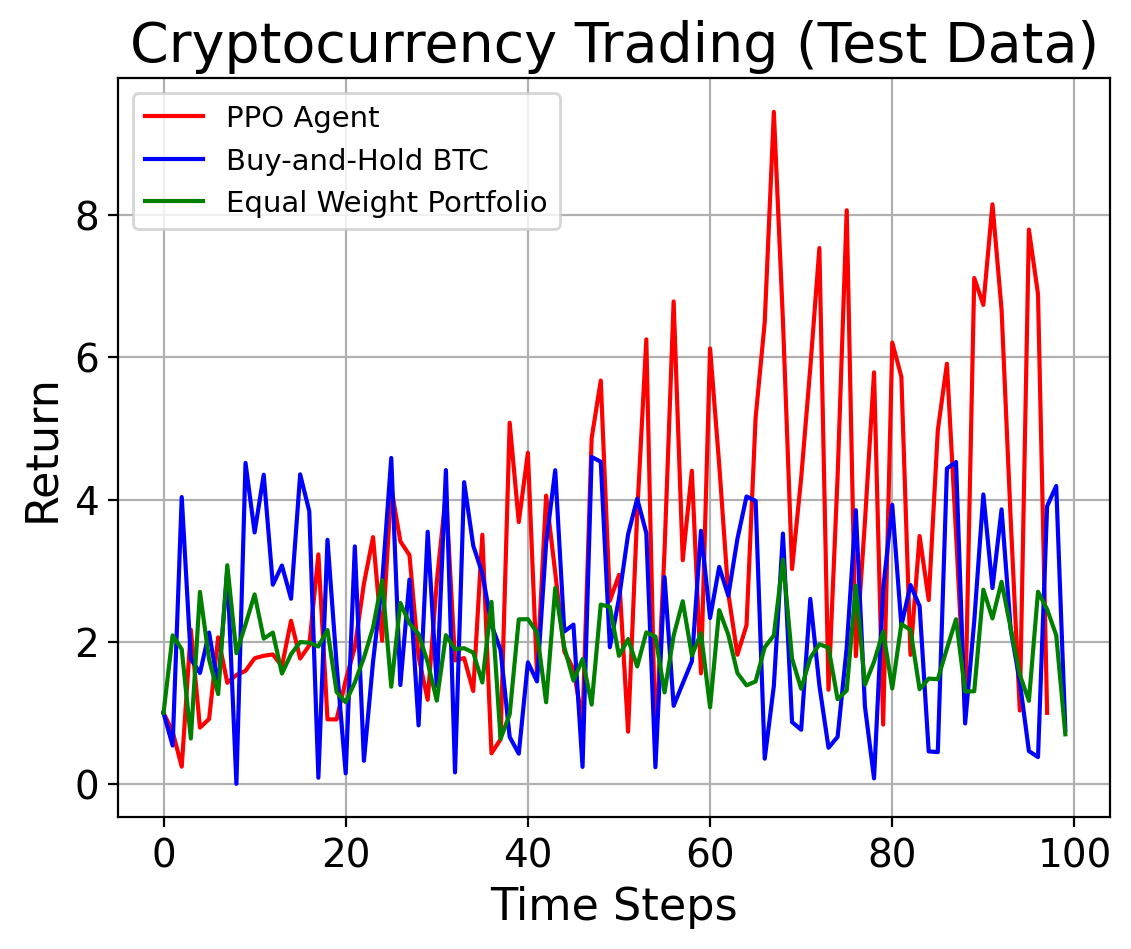

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Get our test data
price_array = env_config['price_array']
btc_prices = price_array[:,0]

#calculate agent returns
agent_returns = account_value_erl/account_value_erl[0]

#calculate buy-and-hold btc returns
buy_hold_btc_returns = btc_prices/btc_prices[0]

#calculate equal weight portfolio returns
initial_prices = price_array[0,:]
equal_weight = np.array([1e5/initial_prices[i] for i in range(len(TICKER_LIST))])
equal_weight_values = []
for i in range(0, price_array.shape[0]):
    equal_weight_values.append(np.sum(equal_weight * price_array[i]))
equal_weight_values = np.array(equal_weight_values)
equal_returns = equal_weight_values/equal_weight_values[0]

#plot 
plt.figure(dpi=200)
plt.grid()
plt.grid(which='minor', axis='y')
plt.title('Cryptocurrency Trading (Test Data)', fontsize=20)
plt.plot(agent_returns, label='PPO Agent', color = 'red')
plt.plot(buy_hold_btc_returns, label='Buy-and-Hold BTC', color='blue')
plt.plot(equal_returns, label='Equal Weight Portfolio', color='green')
plt.ylabel('Return', fontsize=16)
plt.xlabel('Time Steps', fontsize=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(fontsize=10.5)